In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed,SimpleRNN,Dropout,GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")
df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")


In [3]:
df_merged = pd.merge(df, df_truth, on='id')
df_merged

id  cycle  setting1  setting2  setting3      s1      s2       s3  \
0       1      1   -0.0007   -0.0004       100  518.67  641.82  1589.70   
1       1      2    0.0019   -0.0003       100  518.67  642.15  1591.82   
2       1      3   -0.0043    0.0003       100  518.67  642.35  1587.99   
3       1      4    0.0007    0.0000       100  518.67  642.35  1582.79   
4       1      5   -0.0019   -0.0002       100  518.67  642.37  1582.85   
...    ..    ...       ...       ...       ...     ...     ...      ...   
20426  99    181   -0.0015   -0.0001       100  518.67  643.72  1600.39   
20427  99    182   -0.0027   -0.0003       100  518.67  643.52  1605.33   
20428  99    183   -0.0031   -0.0003       100  518.67  643.96  1606.95   
20429  99    184   -0.0010   -0.0001       100  518.67  644.10  1600.20   
20430  99    185   -0.0019   -0.0004       100  518.67  643.93  1598.42   

            s4     s5  ...      s13      s14     s15   s16  s17   s18  s19  \
0      1400.60  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100   
1      1403.14  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100   
2      1404.20  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100   
3      1401.87  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100   
4      1406.22  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100   
...        ...    ...  ...      ...      ...     ...   ...  ...   ...  ...   
20426  1428.03  14.62  ...  2388.29  8123.55  8.4885  0.03  396  2388  100   
20427  1430.32  14.62  ...  2388.27  8130.99  8.5124  0.03  393  2388  100   
20428  1427.90  14.62  ...  2388.31  8126.90  8.5374  0.03  395  2388  100   
20429  1436.54  14.62  ...  2388.33  8125.66  8.5592  0.03  395  2388  100   
20430  1421.56  14.62  ...  2388.24  8127.53  8.5425  0.03  397  2388  100   

         s20      s21  more  
0      39.06  23.4190    98  
1      39.00  23.4236    98  
2      38.95  23.3442    98  
3      38.88  23.3739    98  
4      38.90  23.4044    98  
...      ...      ...   ...  
20426  38.50  23.0425    20  
20427  38.39  22.9674    20  
20428  38.57  23.1440    20  
20429  38.45  23.0478    20  
20430  38.49  23.1931    20  

[20431 rows x 27 columns]

In [4]:
# Step 1: Get the maximum cycle for each engine
max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
max_cycle_per_engine.columns = ['id', 'max_cycle']

# Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

# Step 3: Calculate the actual failure cycle (when engine will fail)
df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

# Step 4: Merge this back with the main DataFrame to compute remaining cycles
df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

# Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
df = df.drop('failure_cycle',axis=1)

In [5]:
df.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004       100  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003       100  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003       100  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000       100  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002       100  518.67  642.37  1582.85  1406.22   

      s5  ...      s13      s14     s15   s16  s17   s18  s19    s20      s21  \
0  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100  39.06  23.4190   
1  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100  39.00  23.4236   
2  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100  38.95  23.3442   
3  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100  38.88  23.3739   
4  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100  38.90  23.4044   

   remaining_cycles  
0               289  
1               288  
2               287  
3               286  
4               285  

[5 rows x 27 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20431 entries, 0 to 20430
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20431 non-null  int64  
 1   cycle             20431 non-null  int64  
 2   setting1          20431 non-null  float64
 3   setting2          20431 non-null  float64
 4   setting3          20431 non-null  int64  
 5   s1                20431 non-null  float64
 6   s2                20431 non-null  float64
 7   s3                20431 non-null  float64
 8   s4                20431 non-null  float64
 9   s5                20431 non-null  float64
 10  s6                20431 non-null  float64
 11  s7                20431 non-null  float64
 12  s8                20431 non-null  float64
 13  s9                20431 non-null  float64
 14  s10               20431 non-null  float64
 15  s11               20431 non-null  float64
 16  s12               20431 non-null  float6

In [7]:
def create_sequences_3(df, window_size=30, test_size=0.1, val_size=0.1):
    """
    Generates scaled sequences and splits into training, validation, and testing sets.
    
    Parameters:
    df (pd.DataFrame): The input dataframe with engine data.
    window_size (int): Number of time steps in each sequence.
    test_size (float): Fraction of data to reserve for testing.
    val_size (float): Fraction of data to reserve for validation.

    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler (np.ndarray): 
    Arrays of train/val/test sequences and targets, feature and target scalers.
    """
    features = [col for col in df.columns if col not in ['id', 'cycle', 'remaining_cycles']]
    target_column = 'remaining_cycles'
    
    # Initialize scalers
    feature_scaler = StandardScaler()
    target_scaler = MinMaxScaler()
    
    # Lists to collect sequences and targets
    X_sequences = []
    y_targets = []
    
    # Group by engine ID and create sliding windows before splitting
    for engine_id, engine_data in df.groupby('id'):
        engine_data = engine_data.sort_values(by='cycle')  # Sort by cycle to keep temporal order
        
        # Create sliding windows
        for i in range(len(engine_data) - window_size):
            X_sequence = engine_data[features].iloc[i:i + window_size].values
            y_target = engine_data[target_column].iloc[i + window_size - 1]  # Target is RUL of last cycle in window
            
            X_sequences.append(X_sequence)
            y_targets.append(y_target)
    
    # Convert to numpy arrays
    X_sequences = np.array(X_sequences)
    y_targets = np.array(y_targets)
    
    # Split data into training+validation and testing
    X_train_val, X_test, y_train_val, y_test = train_test_split(X_sequences, y_targets, test_size=test_size, random_state=42)
    
    # Further split the training+validation data into training and validation
    val_ratio_adjusted = val_size / (1 - test_size)  # Adjust validation size proportionally
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_ratio_adjusted, random_state=42)
    
    # Fit the scalers on the training data
    feature_scaler.fit(X_train.reshape(-1, X_train.shape[2]))  # Reshape for fitting scaler
    target_scaler.fit(y_train.reshape(-1, 1))  # Reshape target for fitting scaler
    
    # Apply the scalers to the data
    X_train = feature_scaler.transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)  # Reshape back after scaling
    X_val = feature_scaler.transform(X_val.reshape(-1, X_val.shape[2])).reshape(X_val.shape)
    X_test = feature_scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)
    
    y_train = target_scaler.transform(y_train.reshape(-1, 1))
    y_val = target_scaler.transform(y_val.reshape(-1, 1))
    y_test = target_scaler.transform(y_test.reshape(-1, 1))
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_scaler, target_scaler


In [8]:
# Example usage:
X_train_single, X_val_single, X_test_single, y_train_single, y_val_single, y_test_single, scaler_single,yscaler_single = create_sequences_3(df, window_size=1, test_size=0.2)
# Check shapes
print("X_train shape:", X_train_single.shape)
print("X_test shape:", X_test_single.shape)
print("y_train shape:", y_train_single.shape)
print("y_test shape:", y_test_single.shape)
print("yscaler data_min:", yscaler_single.data_min_)
print("yscaler data_max:", yscaler_single.data_max_)

X_train shape: (14231, 1, 24)
X_test shape: (4067, 1, 24)
y_train shape: (14231, 1)
y_test shape: (4067, 1)
yscaler data_min: [9.]
yscaler data_max: [455.]


In [9]:
window_size=3
num_features = X_train_single.shape[2]
print(num_features)

X_train_window, X_val_window, X_test_window, y_train_window, y_val_window, y_test_window, scaler_window,yscaler_window = create_sequences_3(df, window_size=window_size, test_size=0.2)
print("X_train shape:", X_train_window.shape)
print("X_test shape:", X_test_window.shape)
print("y_train shape:", y_train_window.shape)
print("y_test shape:", y_test_window.shape)
print("yscaler data_min:", yscaler_window.data_min_)
print("yscaler data_max:", yscaler_window.data_max_)

24
X_train shape: (14093, 3, 24)
X_test shape: (4027, 3, 24)
y_train shape: (14093, 1)
y_test shape: (4027, 1)
yscaler data_min: [9.]
yscaler data_max: [451.]


In [10]:
single_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(1, num_features)),
    Dropout(0.1),
    GRU(128, return_sequences=True),
    Dropout(0.1),
    GRU(64, return_sequences=False),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])
single_model.compile(optimizer=Adam(learning_rate=0.001),loss='mse',metrics=['mse'])

In [11]:
# Train the model
single_history = single_model.fit(X_train_single,y_train_single,
                    validation_data=(X_val_single,y_val_single),
                    epochs=200, batch_size=64,
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=20,monitor='val_loss'))

Epoch 1/200
223/223 [==============================] - 10s 15ms/step - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0208 - val_mse: 0.0208
Epoch 2/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0202 - val_mse: 0.0202
Epoch 3/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0203 - val_mse: 0.0203
Epoch 4/200
223/223 [==============================] - 2s 7ms/step - loss: 0.0191 - mse: 0.0191 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 5/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0200 - val_mse: 0.0200
Epoch 6/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0189 - mse: 0.0189 - val_loss: 0.0199 - val_mse: 0.0199
Epoch 7/200
223/223 [==============================] - 2s 8ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0201 - val_mse: 0.0201
Epoch 8/200
223/223 [==============================] - 2s 8ms/step 

In [12]:
window_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(window_size, num_features)),
    Dropout(0.1),
    GRU(128, return_sequences=True),
    Dropout(0.1),
    GRU(64, return_sequences=False),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

window_model.compile(optimizer=Adam(learning_rate=0.001),loss='mse')

In [13]:
# Train the model
window_history = window_model.fit(X_train_window,y_train_window,
                                  validation_data=(X_val_window,y_val_window),
                    epochs=200, batch_size=64,
                    callbacks=tf.keras.callbacks.EarlyStopping(patience=20,monitor='val_loss'))

Epoch 1/200
221/221 [==============================] - 12s 20ms/step - loss: 0.0235 - val_loss: 0.0208
Epoch 2/200
221/221 [==============================] - 3s 13ms/step - loss: 0.0197 - val_loss: 0.0189
Epoch 3/200
221/221 [==============================] - 3s 13ms/step - loss: 0.0193 - val_loss: 0.0195
Epoch 4/200
221/221 [==============================] - 3s 14ms/step - loss: 0.0191 - val_loss: 0.0189
Epoch 5/200
221/221 [==============================] - 3s 13ms/step - loss: 0.0189 - val_loss: 0.0188
Epoch 6/200
221/221 [==============================] - 3s 13ms/step - loss: 0.0188 - val_loss: 0.0204
Epoch 7/200
221/221 [==============================] - 3s 14ms/step - loss: 0.0188 - val_loss: 0.0187
Epoch 8/200
221/221 [==============================] - 3s 13ms/step - loss: 0.0186 - val_loss: 0.0192
Epoch 9/200
221/221 [==============================] - 3s 14ms/step - loss: 0.0184 - val_loss: 0.0189
Epoch 10/200
221/221 [==============================] - 3s 13ms/step - loss: 0.01

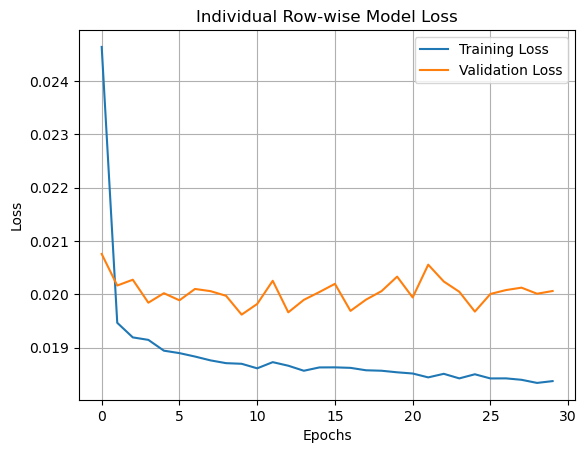

In [14]:
# Plotting function
def plot_loss(history, title,lim=(None,None)):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.ylim(lim)
    plt.grid(True)
    plt.show()

# Plot for individual row-wise model
plot_loss(single_history, 'Individual Row-wise Model Loss')


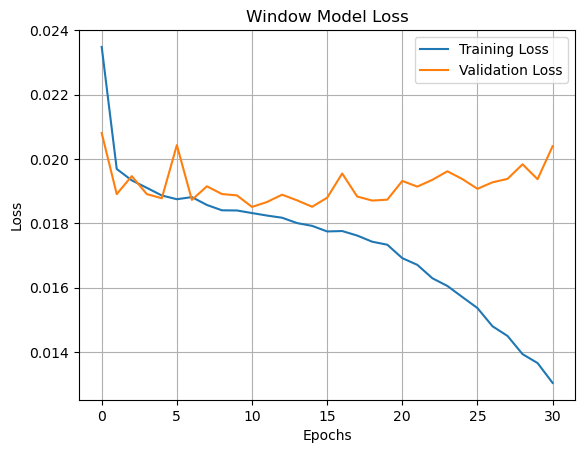

In [15]:
plot_loss(window_history,'Window Model Loss',)

In [16]:
# Adjusted evaluation function
def evaluate_model(model, X_test, y_test,type,scaler):
    predictions = model.predict(X_test)
    if predictions.shape[0] != y_test.shape[0]:
        # Trimming to the minimum size for consistency
        min_len = min(predictions.shape[0], y_test.shape[0])
        predictions = predictions[:min_len]
        y_test = y_test[:min_len]
    rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(predictions.reshape(-1,1))))
    mae = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1,1)), scaler.inverse_transform(predictions.reshape(-1,1)))
    print(f"{type} Model Evaluation - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return predictions, rmse, mae

In [17]:
# Get predictions and evaluate each model individually
pred_single, rmse_single, mae_single = evaluate_model(single_model, X_test_single, y_test_single,'single',yscaler_single)
pred_window, rmse_window, mae_window = evaluate_model(window_model, X_test_window,y_test_window,'window',yscaler_window)

# Evaluate combined predictions
# combined_predictions, rmse_combined, mae_combined = evaluate_combined_model(pred_single, pred_window, )


128/128 [==============================] - 2s 3ms/step
single Model Evaluation - RMSE: 61.07, MAE: 49.05
126/126 [==============================] - 2s 4ms/step
window Model Evaluation - RMSE: 63.08, MAE: 50.28


In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(model, X_test, y_test, type, scaler):
    predictions = model.predict(X_test)
    
    # Trim predictions and targets if they differ in length
    if predictions.shape[0] != y_test.shape[0]:
        min_len = min(predictions.shape[0], y_test.shape[0])
        predictions = predictions[:min_len]
        y_test = y_test[:min_len]
    
    # Reshape for inverse transformation
    y_test = y_test.reshape(-1, 1)
    predictions = predictions.reshape(-1, 1)
    
    # Verify shapes before inverse transformation
    print(f"y_test shape: {y_test.shape}, predictions shape: {predictions.shape}")

    # Perform inverse scaling
    y_test_orig = scaler.inverse_transform(y_test)
    predictions_orig = scaler.inverse_transform(predictions)
    
    # Calculate errors on original scale
    rmse = np.sqrt(mean_squared_error(y_test_orig, predictions_orig))
    mae = mean_absolute_error(y_test_orig, predictions_orig)
    
    print(f"{type} Model Evaluation - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    print("Sample y_test values (original scale):", y_test_orig[:5].flatten())
    print("Sample predictions (original scale):", predictions_orig[:5].flatten())
    
    # print("yscaler data_min:", scaler.data_min_)
    # print("yscaler data_max:", scaler.data_max_)


    return predictions_orig, rmse, mae

# Example usage
pred_single, rmse_single, mae_single = evaluate_model(single_model, X_test_single, y_test_single, 'single', yscaler_single)
pred_window, rmse_window, mae_window = evaluate_model(window_model, X_test_window, y_test_window, 'window', yscaler_window)


128/128 [==============================] - 0s 3ms/step
y_test shape: (4067, 1), predictions shape: (4067, 1)
single Model Evaluation - RMSE: 61.07, MAE: 49.05
Sample y_test values (original scale): [168. 241. 371. 167. 299.]
Sample predictions (original scale): [135.27637 157.49026 224.42448 194.21524 214.102  ]
126/126 [==============================] - 1s 4ms/step
y_test shape: (4027, 1), predictions shape: (4027, 1)
window Model Evaluation - RMSE: 63.08, MAE: 50.28
Sample y_test values (original scale): [117.  50. 167. 214. 173.]
Sample predictions (original scale): [142.57788  116.416245 224.28197  146.08775  167.6244  ]


In [20]:
import matplotlib.pyplot as plt

ypred_window = window_model.predict(X_test_window)

# Assuming y_row_test and ypred_row are already defined as numpy arrays
# y_row_test: Actual values (true labels for the row-wise test data)
# ypred_row: Predicted values from the row-wise model

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6),dpi=1200)
plt.plot(y_test_window, color='orange', label='Actual (y_row_test)', linewidth=2)  # Orange line for actual values
plt.plot(ypred_window, color='blue', label='Predicted (ypred_row)', linewidth=1)  # Blue dashed line for predicted values

# Adding titles and labels
plt.title('Actual vs Predicted Values for Row-Wise Model', fontsize=14)
plt.xlabel('Sample Index', fontsize=12)
plt.xlim(200,400)
plt.ylabel('Remaining Useful Life (RUL)', fontsize=12)
plt.legend()

# Show the plot
plt.grid(True)
# plt.tight_layout()
plt.show()


126/126 [==============================] - 0s 4ms/step


In [21]:
def plot_absolute_error(y_test, y_preds):
    """
    Plots the absolute error per prediction versus the index.
    
    Parameters:
    y_test (np.ndarray): True RUL values.
    y_preds (np.ndarray): Predicted RUL values.
    """
    # Calculate absolute error
    absolute_error = np.abs(y_test - y_preds)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(absolute_error)), absolute_error, color='blue', marker='o', linestyle='-', markersize=3)
    plt.title("Absolute Error per Prediction")
    plt.xlabel("Index")
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.show()

# Example usage:

